# Neural networks with PyTorch

Deep learning networks tend to be massive with dozens or hundreds of layers, making them "deep." You can build one of these deep networks using only weight matrices as we did in the previous notebook, but in general that it very cumbersome and difficult to implement. PyTorch's module `nn` provides a nice way to efficiently build large neural networks.

In [2]:
# Import necessary packages
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch

# Note, uploaded to Colab Files
import helper

import matplotlib.pyplot as plt

Now we will build a larger network that can solve a (formerly) difficult problem, identifying text in an image. Here we will use the MNIST dataset which consists of greyscale handwritten digits. Each image is 28x28 pixels, which you can see below

<img src="https://github.com/udacity/deep-learning-v2-pytorch/raw/master/intro-to-pytorch/assets/mnist.png">

Our goal is to build a neural network that can take one of these images and predict the digit in the image.

First up, we need to get our dataset. This is provided through the `torchvision` package. The code below will download the MNIST dataset, then create training and test datasets for us.



In [3]:
### Run this cell

from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                                ])

# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, 
                          transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


We have the training data loaded into `trainloader` and we make that an iterator with `iter(trainloader)`. Later, we will use this to loop through the dataset for training, like

```python
for image, label in trainloader:
  ## do things with images and labels
```

You will notice that `trainloader` was created with a batch size of 64, and `shuffle=True`. The batch size is the number of images we get in one iteration from the data loader and pass through our network, often called a *batch*. And `shuffle=True` tells it to shuffle the dataset every time we start going through the data loader again. But here we can grab the first batch so that we can check out the data. We can see below that `images` is just a tensor with size `(64, 1, 28, 28)`. So 64 images per batch, 1 color channel, and 28x28 images. 

In [4]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


This is what one of the images looks like:

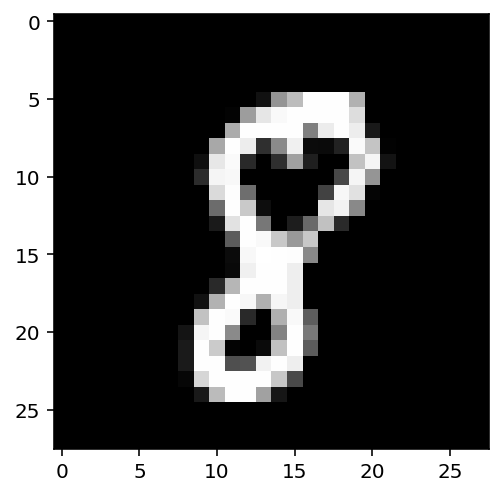

In [5]:
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r')

First, let's try to build a simple network for this dataset using weight matrices and matrix multiplications. Then, we will see how to do it using PyTorch's `nn` module which provides a much more convenient and powerful method for defining network architectures.

The networks you have seen so far are called *fully-connected* or *dense* networks. Each unit in one layer is connected to each unit in the next layer. In fully-connected networks, the input to each layer must be a one-dimensional vector (which can be stacked into a 2D tensor as a batch of multiple examples). However, our images are 28x28 2D tensors, so we need to convert them into 1D vectors. Thinking about sizes, we need to convert the batch of imges with shape `(64, 1, 28, 28)` to have a shape of `(64, 784)`, 784 = 28 x 28. This is typically called *flattening*.

Previously I built a network with one output unit. Here we need 10 output units, one for each unit. We want our network to predict the digit shown in an image, so we will calculate the probabilities that the image is of any one digit or class. This ends up being a discrete probability distribution over the classes (digits) that tells us the most likely class for the image. That means we need 10 output units for the 10 classes (digits). We will see how to convert the network output into a probability distribution next.

>**Exercise**: Flatten the batch of images `images`. Then build a multi-layer network with 784 input units, 256 hidden units, and 10 output units using random tensors for the weights and biases. For now, use a sigmoid activation for the hidden layer. Leave the output layer without an activation. We will add one that gives us a probability distribution next.

In [38]:
flattened_images = images.view((64, -1))

# Alternative
#flattened_images = images.view((images.shape[0], 
#  images.shape[2]*images.shape[3]))

input_nodes = flattened_images.shape[1]
hidden_nodes = 256
output_nodes = 10

def sigmoid_activation(x):
  return 1/(1+torch.exp(-x))

weights_input_hidden = torch.randn((input_nodes, hidden_nodes))
bias_1 = torch.randn(hidden_nodes)

weights_hidden_output = torch.randn((hidden_nodes, output_nodes))
bias_2 = torch.randn(output_nodes)

hidden_layer = torch.mm(flattened_images, weights_input_hidden) + bias_1
hidden_layer = sigmoid_activation(hidden_layer)

out = torch.mm(hidden_layer, weights_hidden_output) + bias_2
print(out.shape)
#print(out)

torch.Size([64, 10])


Now we have 10 outputs for our network. We want to pass in an image to our network and get out a probability distribution over the classes that tells us the likely class(es) the image belongs to. Something that looks like this.

<img src='https://github.com/udacity/deep-learning-v2-pytorch/raw/master/intro-to-pytorch/assets/image_distribution.png' width=500px>

Here we see that the probability for each class is roughly the same. This is representing an untrained network, it has not seen any data yet so it just returns a uniform distribution with equal probabilities for each class.

To calculate this probability distribution, we often use the [**softmax** function](https://en.wikipedia.org/wiki/Softmax_function). Mathematically this looks like

$$
\Large \sigma(x_i) = \cfrac{e^{x_i}}{\sum_k^K{e^{x_k}}}
$$

This squishes each input $x_i$ between 0 and 1 and normalizes the values to give you a proper probability distribution where the probabilities sum up to one.

>*Exercise*: Implement a function `softmax` that performs the softmax calculation and returns probability distributions for each example in the batch. Note that you'll need to pay attention to shapes when doing this. If you have a tensor `a` with shape `(64,10)` and a tensor `b` with shape `(64,)`

In [34]:
# To be completed...

def softmax_activation(x):
  return torch.exp(x)/torch.sum(torch.exp(x), dim=0)

In [35]:
softmax_activation(output_layer[0])

tensor([9.5808e-01, 7.8915e-12, 1.5549e-10, 4.1319e-02, 5.9761e-04, 8.1182e-11,
        2.1571e-08, 8.2933e-13, 9.6443e-09, 1.1414e-14])